<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Text Analytics - Assignment 2
COMPETITION TASK: 

+ Learn the classification model for training set with 5 categorical data from ['business', 'entertainment', 'politics', 'sport', 'tech'].

+ Apply learned model to get the labels for "testdata.csv"

## Team Members: 
Laura Brierton - 15317451, Clodagh Lalor - 13354426, Jeremy Schiff - 18202228, Peter Concannon - 15522467

============================================================================================================================

The following is a jupyter notebook extension to create a table of contents:


In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

# Summary

1. What model(s) did you choose?
<br>NaiveBayes, KNN, KMeans, Random Forest and Logistic Regression, with a ensemble voting model consisting of NB, KNN, RF and Log Reg<br><br>
2. Why did you choose those/that model(s)?
<br>We chose these as they are supervised models that can generate labels with a high degree of accuracy as well as reducing  concerns of overfitting<br><br>
3. Do you think your model can result in a good classification? Why/why not?
<br>Yes, we specifically took an ensemble of our best performing models in order to create an optimum model<br><br>
4. What are the optimal parameters for that model(s)?
<br>We tested these using GridSearchCV and took the best parameters for models such as KNN and Log Reg<br><br>
5. Is the performance increased when training size increases?
<br>Yes, we encountered this problem in the KNN model so we had to cut down the range on values for k in order to increase efficiency without losing accuracy.<br><br>
6. Did you use Cross-validation? Why? 
<br>Yes, we used Cross Validation to split up our training set to test our models before applying them to the examination set. This allowed us to evaluate the accuracy of the models more efficiently.<br><br>
7. Do you think the model suffers from  overfitting or underfitting? Why?
<br>No, we believe the model does not suffer from over/underfitting. We took careful steps to minimise this by invoking a ensemble voting which helps to reduce variance in the individual models contributing to the ensemble system.<br><br>
8. Did you normalise the data before training? Do you think that this helped? Why/Why not?
<br>We normalised the data by using the TF-IDF algorithm, which gives greater weights to words especially common in one document while being uncommon across the whole corpus. By lessening the weight of especially common words, and increasing the weight of less common words, we can better identify the key words of a document, and in turn can use this information in our classifications. <br><br>

**Model Evaluation and Discussion** <br><br>
1. What is your result? What metric did you use? Why?
<br>Our result is a ensemble voting with a high degree of accuracy. We tested the accuracy on our training set and evaluated it using a simple accuracy metric and a log loss metric plotted to a confusion matrix to make it easily readable by a human.<br><br>

2. If you compare models, what difference do you see? Why does one model perform better than the others?
<br>We found that NaiveBayes and Logistic Regression performed the best with 96% and 95% respectively while Random Forest and KNN performed significantly worse, with being the worst performing.<br><br>

3. Complexity for time and data size for models?
<br>We encountered this problem with the KNN model where using to large a range of values for k resulted in a function that took unreasonably long to finish with a result that would be as easily obtained with a smaller range. As such we decided to cut the range from 1 - 5 down to 1 - 2.<br><br>

4. Did you get overfitting/underfitting? How did you overcome those problems if you did?
<br>On our first draft of our voting model we encountered overfitting as a result of a blunt force approach to determining weights. As such we developed an ensemble model to find the optimum weights to ensure no overfitting occurred.<br><br>

5. Your results show you the characteristic of your model, how is it? Bias, variance?
<br>Bias and variance are used as measures how well a model is able to fit a dataset. A dataset with low bias but high variance is said to be overfit, i.e. it is too sensitive to training data. High bias and low variance, meanwhile, is underfit, and not sensitive enough to the data. 
Our use of an ensemble voting system takes several models which may have high variance (i.e. are overfit) and uses the set of them to make predictions. This creates our final model, which is low in both bias and variance. This is reflected in our final model, which is capable of classifying the vast majority of documents correctly. <br><br>

6. Do you think you can improve the performance of your model? How?
<br>With a larger training set we could train a better model to perform on a wider variety of training sets. With more computational power, we could test a wider variety of values for the KNN model and Logistic Regression. Furthermore, we would be able to configure the random forest algorithm to use a higher number of trees in its estimation, reducing the variation across runs and improving accuracy
<br><br>

# Pre-Processing

## Step 1: Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import nltk, json
import math
import itertools
from wordcloud import WordCloud
from nltk import ngrams
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix, f1_score, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.ensemble import VotingClassifier
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize, LinearConstraint, Bounds

We started by importing our training and test datasets and placing them into dataframes:

In [3]:
raw_trainset = pd.read_csv('trainingset.csv',sep='^',header=0)
raw_testdata = pd.read_csv('testdata.csv',sep='^',header=0)
raw_trainset.head()

,content,category
0,French boss to leave EADS The French co-head o...,business
1,"Gamers could drive high-definition TV, films, ...",tech
2,Stalemate in pension strike talks Talks aimed ...,politics
3,Johnny and Denise lose Passport Johnny Vaughan...,entertainment
4,Tautou 'to star in Da Vinci film' French actre...,entertainment


## Step 2: Extract Tokens

We used the below function to tokenise our datasets:

In [4]:
# Define the Function to convert raw text to tokens
def convert_tokens(rawtext, verbose=False):
    # First: Tokenization
    # start by removing hyphens to allow for better tokenization
    rawtext = rawtext.replace('-', ' ')
    pattern = r'\w+'
    tokenizer = RegexpTokenizer(pattern)
    token_words = tokenizer.tokenize(rawtext)
    if (verbose):
        print('Tokens:' + str(token_words[0:10]))
    
    # Second: Decapitalization 
    decap_token_words = [word.lower() for word in token_words]
    if (verbose):
        print('Decapitalized Tokens:' + str(decap_token_words[0:10]))
    
    # Third: Remove stop words
    json_data=open('stopwords.json', encoding="utf8").read()
    stopwords_json = json.loads(json_data)
    stopwords_json_en = set(stopwords_json['en'])
    stopwords_nltk_en = set(stopwords.words('english'))
    # Combine the stopwords
    stoplist_combined = set.union(stopwords_json_en, stopwords_nltk_en)

    
    rmsw_token_words = ([word for word in decap_token_words if word.lower() not in stoplist_combined])
    if (verbose):
        print('Stopwords removed:' + str(rmsw_token_words[0:20]))
    
    ## Fouth: remove CAP words
    rmcap_token_words =[]
    for word in rmsw_token_words:
        if word.isupper():
            rmcap_token_words.append(word.title())
        else:
            rmcap_token_words.append(word)
    if (verbose):
        print('CAPITALIZED removed:' + str(rmcap_token_words[0:20]))
        
     ## Fifth : Remove salutation
    salutation = ['mr','mrs','mss','dr','phd','prof','rev', 'professor']
    rmsalu_token_words = ([word for word in rmcap_token_words if word.lower() not in salutation])
    if (verbose):
        print('Salutation removed:' + str(rmsalu_token_words[0:20]))
        
     ## Sixth: Remove words containing numbers
    rmnb_token_words = ([word for word in rmsalu_token_words if not re.search(r"\d+", word)])
    if (verbose):
        print('Number removed: ' + str(rmnb_token_words[0:20]))
        
    ## define transfer tag function:
    def transfer_tag(treebank_tag):
        if treebank_tag.startswith('j' or 'J'):
            return 'a'
        elif treebank_tag.startswith('v' or 'V'):
            return 'v'
        elif treebank_tag.startswith('n' or 'N'):
            return 'n'
        elif treebank_tag.startswith('r' or 'R'):
            return 'r'
        else:
            # As default pos in lemmatization is Noun
            return 'n'
    
    ## Seventh: Lemmatization
    wnl = WordNetLemmatizer()

    lemma_words = []
    for word, tag in nltk.pos_tag(rmnb_token_words):
        firstletter = tag[0].lower() # -> get the first letter of tag and put them decapitalized form
        wtag = transfer_tag(firstletter) # -> extract the word's tag (noun, verb, adverb, adjective)
        if not wtag:
            lemma_words.extend([word])
        ##please note we had to hardcode the following words in due to an error with word net
        elif word == "boss":
            lemma_words.extend([(word)])
        elif word == "gamers":
            lemma_words.extend([("gamer")])
        else:
            lemma_words.extend([wnl.lemmatize(word, wtag)]) # -> get lemma for word with tag
    if (verbose):
        print('Lemmas : ' + str(lemma_words[0:10]))
        
    
    ## RETURN
    return lemma_words

We tokenized our training and test set separately
<br>
<br>
Extract tokens for training set:

In [5]:
## we next create a dataframe that contained the content category and bag of words for each document
df_handle = raw_trainset.copy()
df_handle["Tokens"] = df_handle.apply(lambda row: convert_tokens(row["content"]), axis=1)
df_handle.head(10)

,content,category,Tokens
0,French boss to leave EADS The French co-head o...,business,"[french, boss, leave, eads, french, head, euro..."
1,"Gamers could drive high-definition TV, films, ...",tech,"[gamer, drive, high, definition, tv, film, gam..."
2,Stalemate in pension strike talks Talks aimed ...,politics,"[stalemate, pension, strike, talk, talk, aim, ..."
3,Johnny and Denise lose Passport Johnny Vaughan...,entertainment,"[johnny, denise, lose, passport, johnny, vaugh..."
4,Tautou 'to star in Da Vinci film' French actre...,entertainment,"[tautou, star, da, vinci, film, french, actres..."
5,Media seek Jackson 'juror' notes Reporters cov...,entertainment,"[medium, seek, jackson, juror, note, reporter,..."
6,Horror film heads US box office A low-budget h...,entertainment,"[horror, film, head, box, office, low, budget,..."
7,Kerr frustrated at victory margin Republic of ...,sport,"[kerr, frustrate, victory, margin, republic, i..."
8,US casino 'tricks' face ban in UK Controversia...,politics,"[casino, trick, face, ban, uk, controversial, ..."
9,Klinsmann issues Lehmann warning Germany coach...,sport,"[klinsmann, issue, lehmann, warn, germany, coa..."


Extract tokens for test set:
<br>
* Note how we dont have the category column in this dataset, as this is what we want our model to ultimately predict!

In [6]:
df_handle_test = raw_testdata.copy()
df_handle_test_onhold = raw_testdata.copy() #on hold until the end of the document
df_handle_test["Tokens"] = df_handle_test.apply(lambda row: convert_tokens(row["content"]), axis=1)
df_handle_test.head(10)

,content,Tokens
0,Eminem secret gig venue revealed Rapper Eminem...,"[eminem, secret, gig, venue, reveal, rapper, e..."
1,Munster Cup tie switched to Spain Munster's He...,"[munster, cup, tie, switch, spain, munster, he..."
2,Eastwood's Baby scoops top Oscars Clint Eastwo...,"[eastwood, baby, scoop, top, oscar, clint, eas..."
3,Spears seeks aborted tour payment Singer Britn...,"[spear, seek, aborted, tour, payment, singer, ..."
4,Gadget show heralds MP3 Christmas Partners of ...,"[gadget, show, herald, christmas, partner, lov..."
5,US Airways staff agree to pay cut A union repr...,"[airways, staff, agree, pay, cut, union, repre..."
6,Blunkett row should end - Blair Prime Minister...,"[blunkett, row, end, blair, prime, minister, t..."
7,Nasdaq planning $100m share sale The owner of ...,"[nasdaq, plan, share, sale, owner, technology,..."
8,Gallery unveils interactive tree A Christmas t...,"[gallery, unveils, interactive, tree, christma..."
9,Escaped prisoner report ordered First Minister...,"[escaped, prisoner, report, order, minister, j..."


We continued the tokenizing process and created entries that contain only the noun or only the adjective tokens.

In [7]:
#Generalization of the extraction
def extract_pos_tokens(tokens, pos):
    # helper for list comprehension
    def is_pos(treebank_tag):
        if treebank_tag.startswith(pos):
            return True
        else:
            return False
    return [word for (word, tag) in nltk.pos_tag(tokens) if is_pos(tag)]

#Specific noun instance
def extract_noun_tokens(tokens):
    # note that this does not include the "or 'n'" component which was both unnecessary and didnt work on my machine
    # furthermore, it does not take noun to be the default
    return extract_pos_tokens(tokens, 'N')
    
#Specific adjective instance
def extract_adj_tokens(tokens):
    # same idea as with nounds - the or 'j' is unneeded
    return extract_pos_tokens(tokens, 'J')

This step adds our noun_token and adjective_token columns to our training dataset:

In [8]:
df_handle["noun_tokens"] = df_handle.apply(lambda row: extract_noun_tokens(row["Tokens"]), axis=1)
df_handle["adjective_tokens"] = df_handle.apply(lambda row: extract_adj_tokens(row["Tokens"]), axis=1)

df_handle.head(10)

,content,category,Tokens,noun_tokens,adjective_tokens
0,French boss to leave EADS The French co-head o...,business,"[french, boss, leave, eads, french, head, euro...","[boss, eads, defence, aerospace, group, statem...","[french, french, european, camus, camus, full,..."
1,"Gamers could drive high-definition TV, films, ...",tech,"[gamer, drive, high, definition, tv, film, gam...","[gamer, drive, definition, tv, film, game, tim...","[high, gear, high, short, popular, sound, expe..."
2,Stalemate in pension strike talks Talks aimed ...,politics,"[stalemate, pension, strike, talk, talk, aim, ...","[pension, strike, talk, talk, aim, strike, pen...","[stalemate, avert, national, public, deputy, p..."
3,Johnny and Denise lose Passport Johnny Vaughan...,entertainment,"[johnny, denise, lose, passport, johnny, vaugh...","[denise, passport, johnny, vaughan, denise, va...","[johnny, saturday, big, plans, bring, real, fo..."
4,Tautou 'to star in Da Vinci film' French actre...,entertainment,"[tautou, star, da, vinci, film, french, actres...","[star, da, vinci, film, actress, star, film, a...","[tautou, french, tautou, female, brown, direct..."
5,Media seek Jackson 'juror' notes Reporters cov...,entertainment,"[medium, seek, jackson, juror, note, reporter,...","[medium, seek, jackson, juror, note, reporter,...","[jackson, complete, potential, vital, potentia..."
6,Horror film heads US box office A low-budget h...,entertainment,"[horror, film, head, box, office, low, budget,...","[horror, film, head, box, office, budget, horr...","[low, evil, dead, raimi, top, north, american,..."
7,Kerr frustrated at victory margin Republic of ...,sport,"[kerr, frustrate, victory, margin, republic, i...","[frustrate, victory, margin, ireland, manager,...","[kerr, republic, brian, friendly, win, republi..."
8,US casino 'tricks' face ban in UK Controversia...,politics,"[casino, trick, face, ban, uk, controversial, ...","[casino, face, ban, uk, casino, trick, trade, ...","[trick, uk, controversial, ban, american, resp..."
9,Klinsmann issues Lehmann warning Germany coach...,sport,"[klinsmann, issue, lehmann, warn, germany, coa...","[klinsmann, issue, coach, jurgen, klinsmann, g...","[germany, arsenal, alive, understudy, kahn, ge..."


Next we do the same for our test set:

In [9]:
df_handle_test["noun_tokens"] = df_handle_test.apply(lambda row: extract_noun_tokens(row["Tokens"]), axis=1)
df_handle_test["adjective_tokens"] = df_handle_test.apply(lambda row: extract_adj_tokens(row["Tokens"]), axis=1)

df_handle_test.head(10)

,content,Tokens,noun_tokens,adjective_tokens
0,Eminem secret gig venue revealed Rapper Eminem...,"[eminem, secret, gig, venue, reveal, rapper, e...","[eminem, gig, venue, rapper, eminem, play, int...","[secret, saturday, river, friday, star, eminem..."
1,Munster Cup tie switched to Spain Munster's He...,"[munster, cup, tie, switch, spain, munster, he...","[munster, cup, switch, spain, munster, quarter...","[tie, heineken, cup, final, real, sociedad, sa..."
2,Eastwood's Baby scoops top Oscars Clint Eastwo...,"[eastwood, baby, scoop, top, oscar, clint, eas...","[eastwood, baby, oscar, clint, eastwood, dolla...","[top, martin, scorsese, top, scorsese, hilary,..."
3,Spears seeks aborted tour payment Singer Britn...,"[spear, seek, aborted, tour, payment, singer, ...","[seek, payment, singer, britney, sue, insuranc...","[spear, tour, spear, onyx, knee, seek, supreme..."
4,Gadget show heralds MP3 Christmas Partners of ...,"[gadget, show, herald, christmas, partner, lov...","[gadget, show, partner, love, tech, expert, pr...","[christmas, present, early, top, irish, irish,..."
5,US Airways staff agree to pay cut A union repr...,"[airways, staff, agree, pay, cut, union, repre...","[staff, pay, cut, union, represent, flight, at...","[airways, cut, â, third, mechanic, cleaner, fa..."
6,Blunkett row should end - Blair Prime Minister...,"[blunkett, row, end, blair, prime, minister, t...","[blunkett, end, blair, minister, tony, blair, ...","[prime, draw, lib, call, fast, nanny, budd, ap..."
7,Nasdaq planning $100m share sale The owner of ...,"[nasdaq, plan, share, sale, owner, technology,...","[nasdaq, plan, share, sale, owner, technology,...","[public, â, full, public, nasdaq, cold, privat..."
8,Gallery unveils interactive tree A Christmas t...,"[gallery, unveils, interactive, tree, christma...","[gallery, tree, christmas, receive, text, mess...","[unveils, interactive, tree, unveil, london, a..."
9,Escaped prisoner report ordered First Minister...,"[escaped, prisoner, report, order, minister, j...","[prisoner, report, order, minister, jack, mcco...","[escaped, schizophrenic, high, snp, nicola, re..."


## Step 3: Deconstruction - Wordclouds and Frequency 

### Wordcloud

Next we decided to create a wordcloud for the entire corpus, to get an idea of the most common words and if there was any common pattern. We thought that it might help us to decide if there were any more pre-processing steps we needed to take before moving onto our Analysis stage.

In [10]:
## Wordcloud function
def wordcloudplot(tokens, name):
    
    text2 = ' '.join(tokens)

    wordcloud = WordCloud(width=1600, height=800).generate(text2)
    plt.figure( figsize=(20,10), facecolor='k')
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    
    # save to file if filename given
    if name:
        wordcloud.to_file(name)
        
    plt.show()

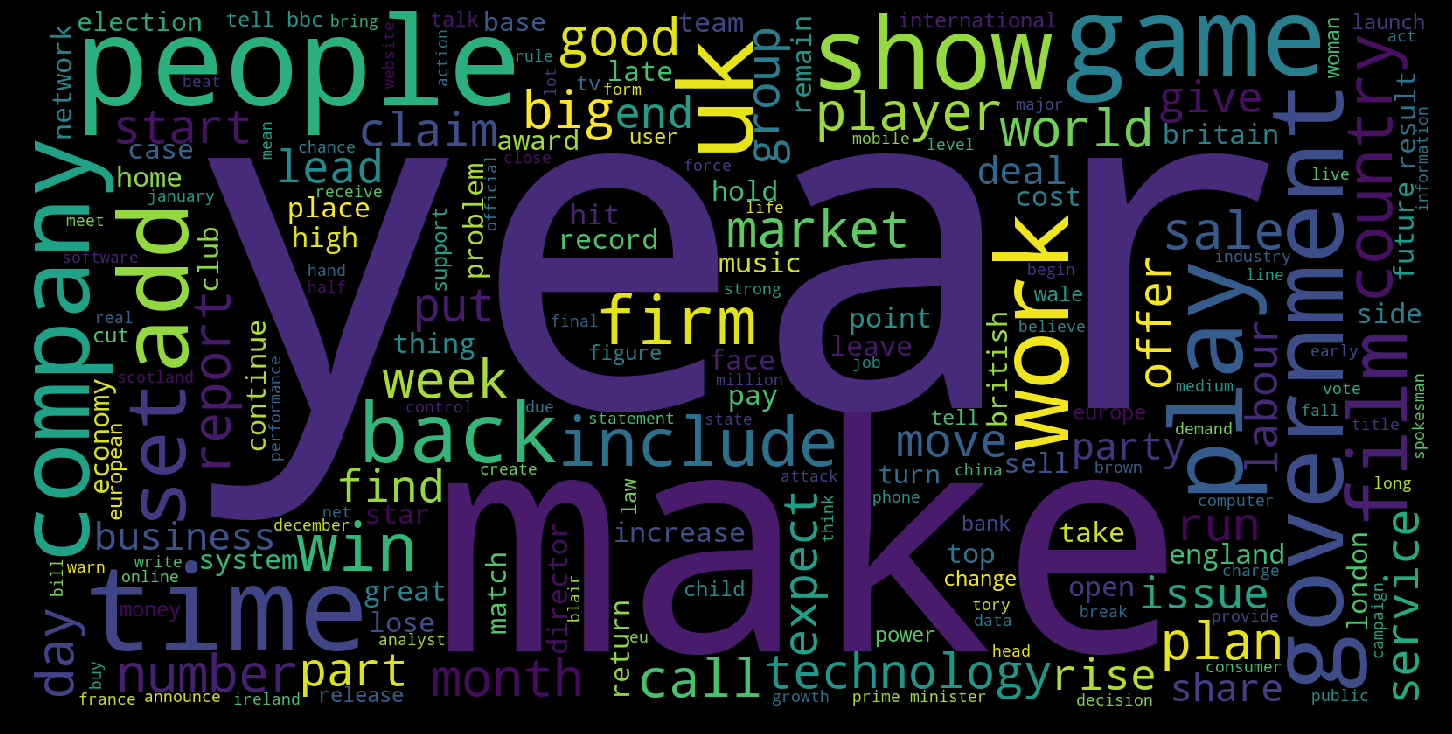

In [11]:
#joined tokens refers to all the tokens from all the documents in the training data dataframe
joined_tokens = [token for document in df_handle["Tokens"] for token in document]

#saves wordcloud of all tokens as file. Please note, this word cloud is for all tokens not just noun tokens
wordcloudplot(joined_tokens, 'img_wordcloud1.png')

Looking at our word cloud, we can see immediately that a lot of verbs are present, this will not necessarily help us with our classification step and so this influenced us to look at noun and adjective tokens instead, going forward.

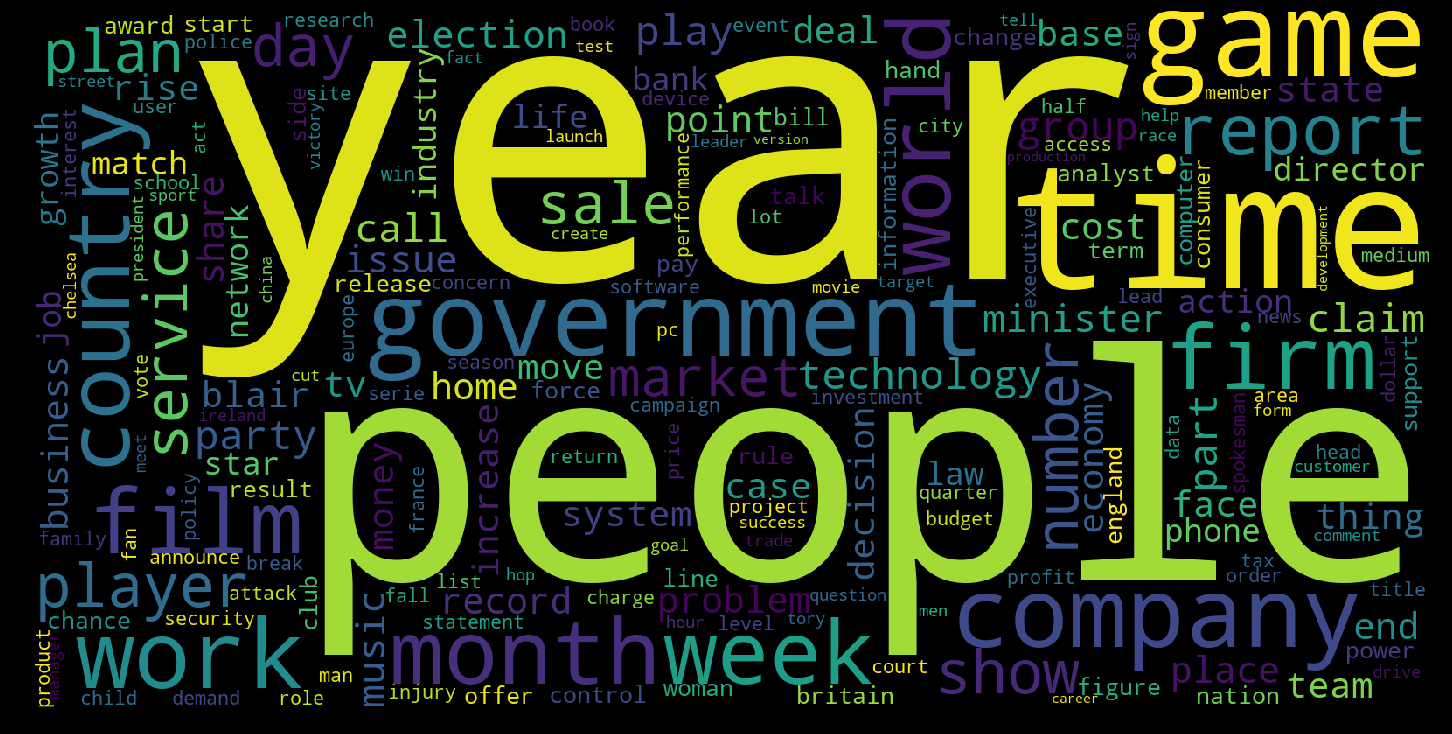

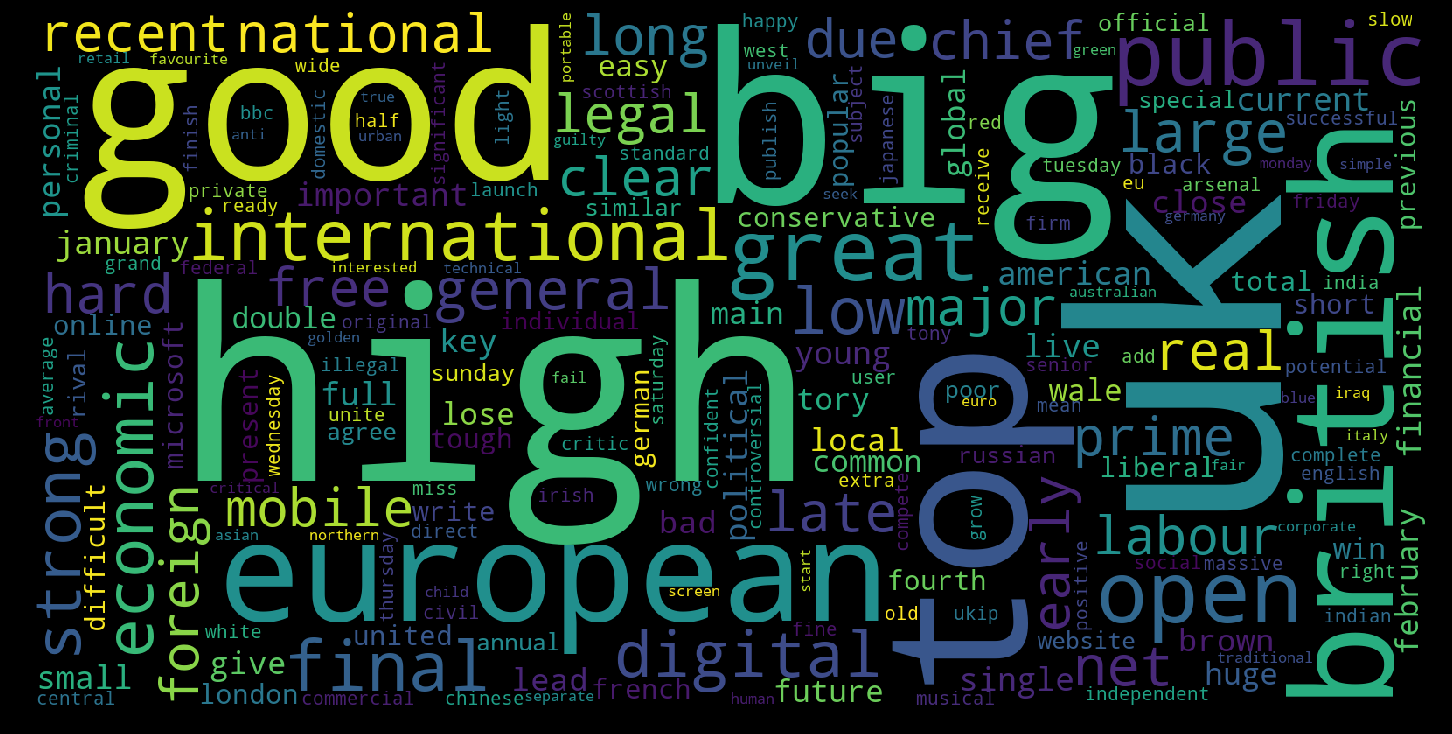

In [12]:
noun_tokens = [token for document in df_handle["noun_tokens"] for token in document]
adjective_tokens = [token for document in df_handle["adjective_tokens"] for token in document]
wordcloudplot(noun_tokens, 'img_wordcloud2.png')
wordcloudplot(adjective_tokens, 'img_wordcloud3.png')

Looking at these separate wordclouds separately gives us a nice overview of our trainin dataset. We can see a good reflection of the known classes used. It indicates to us a pretty balanced dataset as a result.

### Frequency

Building on this, we wanted to look at the frequency of certain nouns and adjectives overall in the data with hopes that we could glean some information to aid classification.

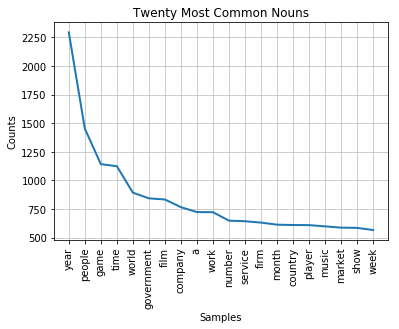

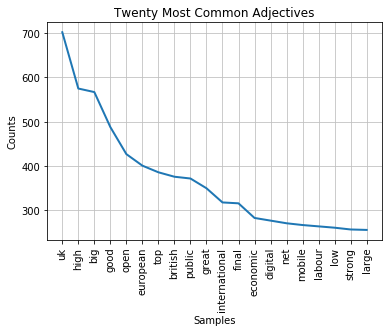

In [13]:
joined_noun_tokens = [token for document in df_handle["noun_tokens"] for token in document]
word_frequency = nltk.FreqDist(joined_noun_tokens)
word_frequency.plot(20, title='Twenty Most Common Nouns')

joined_adjective_tokens = [token for document in df_handle["adjective_tokens"] for token in document]
word_frequency = nltk.FreqDist(joined_adjective_tokens)
word_frequency.plot(20, title='Twenty Most Common Adjectives')

The nouns looks pretty useful with words like government, film, and game all likely being high indicators as to the category of the data. On the other hand, the adjectives seem much less useful with words like high, big, and good being so prevalent.

# Analysis

## Step 4 : Most Common Bigrams and Trigrams

Another part of our analysis involved looking at bigrams and trigrams, which we thought might aid us in classification.

### Bigrams

In [14]:
joined_tokens = [token for document in df_handle["Tokens"] for token in document]

bigram = ngrams(joined_tokens, 2)
bi_frequencies = nltk.FreqDist(bigram)
dict_items =list(dict(bi_frequencies).items())
#make a dataframe of the bigrams and their frequencies
df_bigramFreq = pd.DataFrame(dict_items, columns=['bigram','freq']).sort_values(by='freq', ascending=False)
df_bigramFreq = df_bigramFreq.reset_index(drop=True)
#show only top five
df_bigramFreq.head(5)

,bigram,freq
0,"(tell, bbc)",244
1,"(prime, minister)",230
2,"(chief, executive)",138
3,"(year, ago)",127
4,"(tony, blair)",127


In [15]:
# Function to check the gram is noun gram or not
def IsNounGram(ngram):
    if ('-pron-' in ngram) or ('t' in ngram):
        return False
    
    first_type = ('JJ','JJR','JJS','NN','NNS','NNP','NNPS')
    second_type = ('NN','NNS','NNP','NNPS')
    tags = nltk.pos_tag(ngram,lang='eng')
    if (tags[0][1] in first_type) and (tags[1][1] in second_type):
        return True
    else:
        return False

In [16]:
##we decided to look only at top 50 for efficiency sake
df_bigramFreq_filter = df_bigramFreq.copy().head(50)
#create a new column which check for each bigram, which are noun grams , returns true or false
df_bigramFreq_filter['noun_gram'] = df_bigramFreq_filter["bigram"].map(lambda x : IsNounGram(x))
#filter out those that are false
df_bigramFreq_filter = df_bigramFreq_filter[df_bigramFreq_filter.noun_gram != False]
df_bigramFreq_filter.head(5)

,bigram,freq,noun_gram
0,"(tell, bbc)",244,True
1,"(prime, minister)",230,True
2,"(chief, executive)",138,True
4,"(tony, blair)",127,True
5,"(bbc, news)",123,True


We can see from this that our top five have changed a little (as has the entire dataframe). We were concerned with the (tell, BBC) bigram, and so decided that we needed to add an additional step of checking that this appeared in the text.

In [17]:
##check that these ngrams actually appear together in the text!
def CheckWordInText(word, Text):
    if word in Text.lower():
        return True
    else:
        return False

In [18]:
#combine all texts
full_corpus =' '.join([document for document in df_handle["content"]])
# combine all the tokens
for index, row in df_handle.iterrows():
    full_corpus = full_corpus + df_handle['content'].iloc[index]

In [19]:
## this step adds a column stating that the n-gram appears as is, in the text
df_real_bigram = df_bigramFreq_filter.copy()

#true if exists
exists_list = []
for index, row in df_bigramFreq_filter.iterrows():
    gram = row['bigram']
    word = (' '.join(gram))
    exists_list.append(CheckWordInText(word, full_corpus))

#create new column for these    
df_bigramFreq_filter['exist'] = exists_list    

#delete those that are false
df_real_bigram = df_bigramFreq_filter[df_bigramFreq_filter.exist != False]

#show top 5
df_real_bigram.head(5)

,bigram,freq,noun_gram,exist
1,"(prime, minister)",230,True,True
2,"(chief, executive)",138,True,True
4,"(tony, blair)",127,True,True
5,"(bbc, news)",123,True,True
6,"(general, election)",119,True,True


We shall now do the same for trigrams. 

### Trigrams

In [20]:
joined_tokens = [token for document in df_handle["Tokens"] for token in document]
trigram = ngrams(joined_tokens, 3)
tri_frequencies = nltk.FreqDist(trigram)
dict_items = list(dict(tri_frequencies).items())
#make a dataframe of the trigrams and their frequencies
df_trigramFreq = pd.DataFrame(dict_items, columns=['trigram','freq']).sort_values(by='freq', ascending=False)
df_trigramFreq = df_trigramFreq.reset_index(drop=True)

#check for noun grams
##look only at top 50 for efficiency sake
df_trigramFreq_filter = df_trigramFreq.copy().head(50)
#creaete a new column which check for each bigram, which are noun grams , returns true or false
df_trigramFreq_filter['noun_gram'] = df_trigramFreq_filter["trigram"].map(lambda x : IsNounGram(x))
#filter out those that are false
df_trigramFreq_filter = df_trigramFreq_filter[df_trigramFreq_filter.noun_gram != False]
#printf(df_bigramFreq_filter.head(5))

#check in text
df_real_trigram = df_trigramFreq_filter.copy()

exits_list = []
for index, row in df_trigramFreq_filter.iterrows():
    gram = row['trigram']
    word = (' '.join(gram))
    exits_list.append(CheckWordInText(word, full_corpus))
    
df_real_trigram['exist'] = exits_list
df_real_trigram = df_real_trigram.loc[df_real_trigram.exist==True]


#df_trigramFreq_filter.head(5)
df_real_trigram.head(5)

,trigram,freq,noun_gram,exist
1,"(bbc, news, website)",63,True,True
3,"(leader, michael, howard)",40,True,True
8,"(tory, leader, michael)",28,True,True
9,"(chancellor, gordon, brown)",24,True,True
10,"(leader, charles, kennedy)",21,True,True


After looking at the results from our bigrams and trigrams, we decided **against** using them for classification purposes. Looking at the top 5 of both, we thought that they were mostly only relevant for the politics class and therefore by using bigrams and trigrams as part of our model we may bias, what looks to be, a fairly balanced dataset.

# Vectorization

TF-IDF vectorisation is used for identifying significant words within the dataset, giving greater wieght to words that are uncommon across the full corpus.

## Step 5: Vectorising the training set

TF-IDF vectorisation is used for identifying significant words within documents, giving greater weight to words that are especially common in an individual document while being uncommon across the full corpus. By doing so, we can get an idea of what words are especially important within individual documents, and use this information to better classify documents in the corpus.

The structure of the TF-IDF vectors must constant in order to use them for most models. Because of this, words will be present in the TF-IDF vectors if and only if they appear in the training data (after normalisation). Therefore, certain words which would have had greater weights in documents in the test dataset will be discarded. This should have minimal impact on our model's ability to classify with TF-IDF, as the absense of those words from the training set means that the models will have no known values for the new words, and will therefore be unable to use them. 

In [21]:
#the sample output given shows only zeros but it is working
merged_tokens = [" ".join(x) for x in df_handle["noun_tokens"]]
tfidf_vectorizer = TfidfVectorizer(norm=None)
tfidf_train = pd.DataFrame(tfidf_vectorizer.fit_transform(merged_tokens).todense(), columns = tfidf_vectorizer.get_feature_names())
tfidf_train.head(5)

,aa,aaa,aaas,aac,aadc,aaliyah,aamir,aan,aarhus,aaron,...,zone,zonealarm,zoom,zooropa,zornotza,zubair,zurich,zutons,zvonareva,zvyagintsev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Step 6: Vectorising the test set

In [22]:
test_clean_data = [" ".join(x) for x in df_handle_test.Tokens]

# Create a tfidf for the test data with the same dimensions (i.e. headers)
# as the set above. necessary for comparing models
tfidf_clean = tfidf_vectorizer.transform(test_clean_data)
## For printing that tf-idf matrix, we convert it into dataframe
tfidf_test = pd.DataFrame(tfidf_clean.toarray(),columns=[tfidf_vectorizer.get_feature_names()])
tfidf_test.head(5)

,aa,aaa,aaas,aac,aadc,aaliyah,aamir,aan,aarhus,aaron,...,zone,zonealarm,zoom,zooropa,zornotza,zubair,zurich,zutons,zvonareva,zvyagintsev
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Model Learning

## Step 7: Class Analysis

In [23]:
# this takes our known labels from the dataframe to use for training our model
labels_train = df_handle['category']

We decided to plot the frequency of the labels to ensure that we had a fairly balanced dataset.

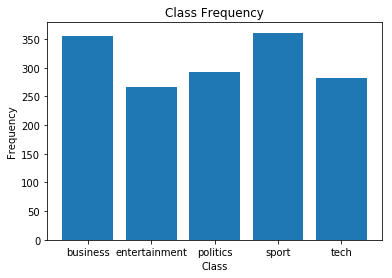

In [24]:
import matplotlib.pyplot as plt

unique, counts = np.unique(labels_train, return_counts=True)

plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

From this plot we can see this is a balanced dataset, and this reinforced our decision not to use bigrams and trigrams, especially as politics is not the most frequent class and as such we could bias our model.

## Step 8: Select Classifiers

### K Fold Cross-Validation

We created a validation set to apply our developed models to before we applied them to the test set

In [25]:
validation_size = 0.1
num_folds = 10
model_tfidf, validation_tfidf, model_labels, validation_labels = train_test_split(tfidf_train, labels_train, test_size=validation_size, shuffle=True, stratify=labels_train)

### BAYES classifier

In [26]:
modelbayes = MultinomialNB()
modelbayes.fit(model_tfidf, model_labels)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

### Random Forest classifier

In [27]:
randomforest = RandomForestClassifier()
randomforest.fit(model_tfidf, model_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### K-Means classifier

In [28]:
modelkmeans = KMeans(n_clusters=5, init='k-means++', max_iter=200, n_init=100)
modelkmeans.fit(model_tfidf)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=200,
    n_clusters=5, n_init=100, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

### KNN classifier

Below, we attempt to use GridSearchCV to identify the ideal value for k in the kNN classifier. Calculating this hyperparameter is costly, as it requires the creation of a kNN model for each possible value in the given set. Although the set of possible values here is kept small in our submission notebook for the sake of running faster, we did run tests on the range \[1, 2, 3, 4, 5\], and still found that 1 was the optimal value for accuracy. 

The difference between documents of differing classification is small enough that comparing to more than the singular nearest neighbour results in more incorrect classifications. Using k=1 may be a case of overfitting the data: a lower value for k gives a more complex model with lower bias and higher variance. However, this is not likely to be an issue, as our use of ensemble classification will help to greatly reduce the variance of the final classifier.

In [29]:
#takes about 5-6 mins to complete
# we only used 1 to 2 here as this step takes so long. Please note that we had tried for [1,..,5] but after it ran for about 30 mins, determined that the optimum is actually within the range [1,2] so dicided to fo with this for efficiencies sake
k_values = [1,2]
print("the range of k is " + str(k_values))
grid_search = GridSearchCV(KNeighborsClassifier(), {'n_neighbors':k_values}, scoring='accuracy', cv = num_folds)
grid_search.fit(model_tfidf, model_labels)

the range of k is [1, 2]


GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [1, 2]}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='accuracy',
       verbose=0)

The following step will take the optimum k value determined in the previous step and use that for our k neighbours classifier:

In [30]:
modelknn = KNeighborsClassifier(**grid_search.best_params_)
modelknn.fit(model_tfidf, model_labels)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

According to this subset, the best value is k=1

### Logistic classifier

In [31]:
c_values = [1e-10, 1e-8, 1e-6, 1e-4, 1e-2, 1, 1e2]
grid_search = GridSearchCV(LogisticRegression(), {'C':c_values}, scoring='accuracy', cv = num_folds)
grid_search.fit(model_tfidf, model_labels)

modellr = LogisticRegression(**grid_search.best_params_)
modellr.fit(model_tfidf, model_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

## Step 9: Applying models to validation set to estimate accuracy

Next we decided to apply our models to our partitioned vaidation set to see how they performed. We chose Log Loss as our main evaluation metric because it maps real numbers with probability in the smoothest manner amking it useful when dealing with confidence, which we want to because we know that later on we will be using a voting model that takes this confidence into account.

In [32]:
#Credit to: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [33]:
#General purpose function to perform our error analysis via a variety of different mechanisms
def perform_error_analysis(model, model_name):
    predicted_labels = model.predict(validation_tfidf)
    predicted_probas = model.predict_proba(validation_tfidf)
    accuracy = accuracy_score(validation_labels, predicted_labels)
    f1 = f1_score(validation_labels, predicted_labels, average='weighted')
    l_loss = log_loss(validation_labels, predicted_probas)
    print('Accuracy rate for ' + model_name + ': {:0.2f}%'.format(accuracy * 100))
    print('F1 (balanced accuracy rate) for ' + model_name + ': {:0.2f}%'.format(f1 * 100))
    print('Log loss for ' + model_name + ': {:0.2f}'.format(l_loss))
    class_names = labels_train.unique()
    cnf_matrix = confusion_matrix(validation_labels, predicted_labels)
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                          title='Normalized confusion matrix')
    plt.show()


We proceed by using our above function on the various models we created.

### Naive Bayes

Accuracy rate for Naive Bayes: 98.08%
F1 (balanced accuracy rate) for Naive Bayes: 98.06%
Log loss for Naive Bayes: 0.45


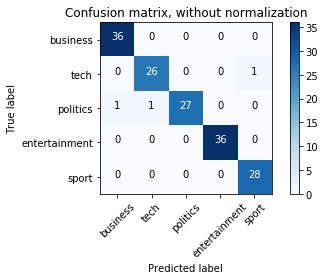

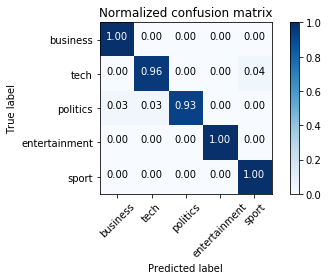

In [34]:
perform_error_analysis(modelbayes, "Naive Bayes")

### RandomForest

Accuracy rate for Random Forest: 89.10%
F1 (balanced accuracy rate) for Random Forest: 88.90%
Log loss for Random Forest: 0.85


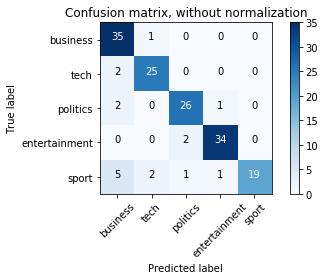

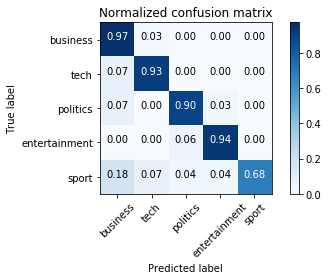

In [35]:
perform_error_analysis(randomforest, "Random Forest")

### KMeans

KMeans requires a little more work here as it is an unsupervised algorithm. The following predicts the clusters, but currently they are labelled 0-4 and as such we need to set these clusters as actually category labels so that we can discover how well this method has worked.



In [36]:
predicted_labels_kmeans = modelkmeans.predict(validation_tfidf)
modelkmeans = KMeans(n_clusters=5, init='k-means++')
modelkmeans.fit(tfidf_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=5, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

To find the corresponding names for the clusters I applied the kmeans to the whole set and looked at the most common category for each. I quickly learned that the number of iterations i would need to make on my model to make it provide even sized clusters that I could confidently label as the five categories, simply took far too much time to make this an optimal model to use in the future.

In [37]:
all_predicted_label = modelkmeans.predict(tfidf_train)
newdf = df_handle.copy()
newdf["Cluster"] = all_predicted_label
newdf.head(3)
cluster0df = newdf.loc[newdf['Cluster'].isin(['0'])]
cluster1df = newdf.loc[newdf['Cluster'].isin(['1'])]
cluster2df = newdf.loc[newdf['Cluster'].isin(['2'])]
cluster3df = newdf.loc[newdf['Cluster'].isin(['3'])]
cluster4df = newdf.loc[newdf['Cluster'].isin(['4'])]

In [45]:
print(cluster0df.shape)
print(cluster1df.shape)
print(cluster2df.shape)
print(cluster3df.shape)
print(cluster4df.shape)

(1, 6)
(17, 6)
(2, 6)
(1536, 6)
(1, 6)


### KNN

Accuracy rate for KNN: 72.44%
F1 (balanced accuracy rate) for KNN: 73.36%
Log loss for KNN: 9.52


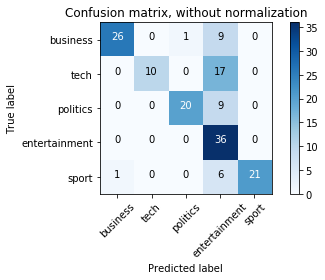

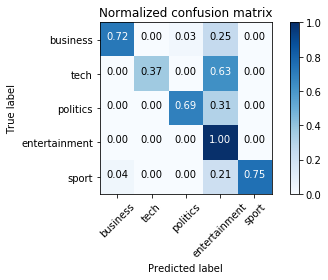

In [46]:
perform_error_analysis(modelknn, "KNN")

### Logistic Regression

Accuracy rate for Logistic Regression: 95.51%
F1 (balanced accuracy rate) for Logistic Regression: 95.45%
Log loss for Logistic Regression: 0.81


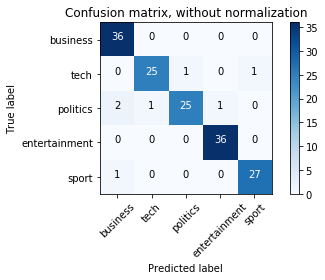

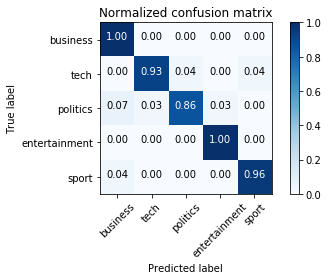

In [47]:
perform_error_analysis(modellr, "Logistic Regression")

One can see that in general logistic regression and naive bayes have the highest performance, but that each model does better or worse at handling certain classes. This suggests the possibility of an ensemble model as we will see later.

# Step 10: Applying Model to Test Set

Finally, after training our model, we can now apply it to our test set.
<br>
<br>
We applied each of the four models that we currently have and added them as columns to a dataframe for easy comparison:

In [48]:
predicted_test_labels_bayes = modelbayes.predict(tfidf_test)
predicted_test_labels_rf = randomforest.predict(tfidf_test)
predicted_test_labels_knn = modelknn.predict(tfidf_test)
predicted_test_labels_lr = modellr.predict(tfidf_test)

In [49]:
df_handle_test_onhold["Pred Labels Bayes"] = predicted_test_labels_bayes
df_handle_test_onhold["Pred Labels RF"] = predicted_test_labels_rf
df_handle_test_onhold["Pred Labels KNN"] = predicted_test_labels_knn
df_handle_test_onhold["Pred Labels LR"] = predicted_test_labels_lr
df_handle_test_onhold.to_csv('predicted labels.csv')
df_handle_test_onhold.head()

,content,Pred Labels Bayes,Pred Labels RF,Pred Labels KNN,Pred Labels LR
0,Eminem secret gig venue revealed Rapper Eminem...,entertainment,entertainment,entertainment,entertainment
1,Munster Cup tie switched to Spain Munster's He...,sport,sport,sport,sport
2,Eastwood's Baby scoops top Oscars Clint Eastwo...,entertainment,entertainment,entertainment,entertainment
3,Spears seeks aborted tour payment Singer Britn...,entertainment,entertainment,sport,entertainment
4,Gadget show heralds MP3 Christmas Partners of ...,tech,business,tech,tech


We first wanted to see if all of our models agreed on their class label for each document. To do this, we compared where the models agreed and where they disagreed. 

In [50]:
count_agree = 0
count_disagree = 0

for index, row in df_handle_test_onhold.iterrows():
    if row["Pred Labels Bayes"]==row["Pred Labels RF"]==row["Pred Labels KNN"]==row["Pred Labels LR"]:
        count_agree += 1
    else:
        count_disagree += 1
        
print("Number of articles agreed on by the models: {:0.2f}%".format((count_agree/df_handle_test_onhold.shape[0])*100) )
print("Number of articles disagreed on by the models: {:0.2f}%".format((count_disagree/df_handle_test_onhold.shape[0])*100))

Number of articles agreed on by the models: 72.75%
Number of articles disagreed on by the models: 27.25%


As we can see, the models agree with each other 70% of the time. Based on this we decided that we wanted to use a voting model to find a consensus on cases where the models disagreed.

# Step 11: Classifier Voting

The following is an unweighted voting system. It uses the previous models to create a voting classifier and we then fit this model to the validation set.

In [51]:
eclf_unweighted = VotingClassifier(estimators=[('nb', modelbayes), ('rf', randomforest), ('knn', modelknn), ('lr', modellr)], voting='soft')
eclf_unweighted.fit(model_tfidf, model_labels)

VotingClassifier(estimators=[('nb', MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
   ...ty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

We then tested this model on the validation set:

C:\Users\cloda\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy rate for Unweighted Voting Classifier: 96.15%
F1 (balanced accuracy rate) for Unweighted Voting Classifier: 96.09%
Log loss for Unweighted Voting Classifier: 0.38


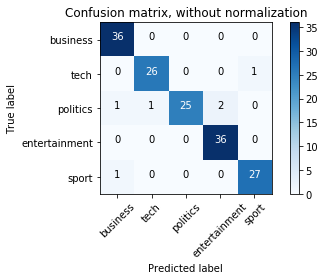

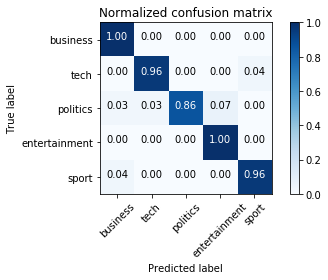

In [52]:
perform_error_analysis(eclf_unweighted, "Unweighted Voting Classifier")

This improved the log loss slightly, but does not quite achieve the results we were hoping for. To improve the voting, we introudce a full-fledged ensemble classifier that takes in the predicted probabilities from each model for use in classification.

In [53]:
#This class has a lot of boilerplate, but in general the idea is to simply create a classifier that takes other classifiers as input
#This shares an API with general skl models
class Ensembler():

    def __init__(self, num_folds, model_list, scoring='accuracy'):
        self.models = model_list
        self.folds = num_folds
        self.regressor = LogisticRegression()

    def fit(self, X, y):
        self.num_classes = y.nunique()
        model_vals = pd.DataFrame(index=range(X.shape[0]), columns=range(len(self.models) * self.num_classes))
        kf = KFold(n_splits = self.folds)
        for train, test in kf.split(X):
            i = 0
            for model in self.models:
                model.fit(X.iloc[train], y.iloc[train])
                test_predictions = model.predict_proba(X.iloc[test])
                for j in range(0, self.num_classes):
                    model_vals[i * self.num_classes + j].iloc[test] = [pred[j] for pred in test_predictions]
                i += 1
        model_vals = model_vals.astype(float)
        self.regressor.fit(model_vals, y)
        for model in self.models:
            model.fit(X, y)
        return self

    def predict(self, X, y=None):
        model_vals = pd.DataFrame(index=range(X.shape[0]), columns=range(len(self.models) * self.num_classes))
        i = 0
        for model in self.models:
            predictions = model.predict_proba(X)
            for j in range(0, self.num_classes):
                model_vals[i * self.num_classes + j] = [pred[j] for pred in predictions]
            i += 1
        model_vals = model_vals.astype(float)
        return self.regressor.predict(model_vals)

    def predict_proba(self, X, y=None):
        model_vals = pd.DataFrame(index=range(X.shape[0]), columns=range(len(self.models) * self.num_classes))
        i = 0
        for model in self.models:
            predictions = model.predict_proba(X)
            for j in range(0, self.num_classes):
                model_vals[i * self.num_classes + j] = [pred[j] for pred in predictions]
            i += 1
        model_vals = model_vals.astype(float)
        return self.regressor.predict_proba(model_vals)

With the ensembler designed, we will use it on our four main models and check the error.

C:\Users\cloda\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Accuracy rate for Ensemble Classifier: 97.44%
F1 (balanced accuracy rate) for Ensemble Classifier: 97.43%
Log loss for Ensemble Classifier: 0.12


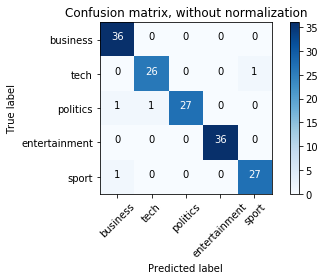

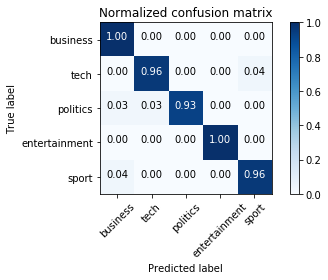

In [54]:
model_list = [modelbayes, randomforest, modelknn, modellr]
ensembler = Ensembler(num_folds, model_list)
ensembler.fit(model_tfidf, model_labels)
perform_error_analysis(ensembler, "Ensemble Classifier")

This is a fantastic result - we classify more values correct than any individual model and misclassify with very low confidence. Such a model is likely to have learned something truly fundamental on the data and will likely classify the test set very accurately.

# Step 12: Final Model Application

Finally, we added our final predicted class labels as a new column to our dataframe:

In [55]:
predicted_test_labels = ensembler.predict(tfidf_test)
df_handle_test_onhold["Pred Labels ECLF-W"] = predicted_test_labels
df_handle_test_onhold.to_csv('predicted labels final.csv')

In [56]:
df_handle_test_onhold.head()

,content,Pred Labels Bayes,Pred Labels RF,Pred Labels KNN,Pred Labels LR,Pred Labels ECLF-W
0,Eminem secret gig venue revealed Rapper Eminem...,entertainment,entertainment,entertainment,entertainment,entertainment
1,Munster Cup tie switched to Spain Munster's He...,sport,sport,sport,sport,sport
2,Eastwood's Baby scoops top Oscars Clint Eastwo...,entertainment,entertainment,entertainment,entertainment,entertainment
3,Spears seeks aborted tour payment Singer Britn...,entertainment,entertainment,sport,entertainment,entertainment
4,Gadget show heralds MP3 Christmas Partners of ...,tech,business,tech,tech,tech


In [57]:
df_handle_test_onhold[["content", "Pred Labels ECLF-W"]]

,content,Pred Labels ECLF-W
0,Eminem secret gig venue revealed Rapper Eminem...,entertainment
1,Munster Cup tie switched to Spain Munster's He...,sport
2,Eastwood's Baby scoops top Oscars Clint Eastwo...,entertainment
3,Spears seeks aborted tour payment Singer Britn...,entertainment
4,Gadget show heralds MP3 Christmas Partners of ...,tech
5,US Airways staff agree to pay cut A union repr...,business
6,Blunkett row should end - Blair Prime Minister...,politics
7,Nasdaq planning $100m share sale The owner of ...,business
8,Gallery unveils interactive tree A Christmas t...,entertainment
9,Escaped prisoner report ordered First Minister...,politics


Out of interest we decided to have a look at our predicted labels to see if this test set was also a fairly balanced dataset. Interestingly it is!

In [59]:
df_handle_test_onhold['Pred Labels ECLF-W'].value_counts()

sport            150
business         142
politics         129
tech             127
entertainment    120
Name: Pred Labels ECLF-W, dtype: int64

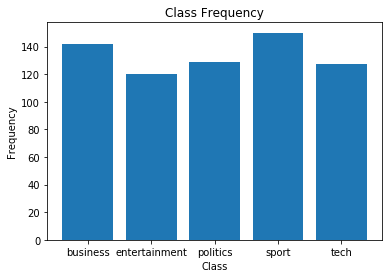

In [60]:
import matplotlib.pyplot as plt

unique, counts = np.unique(df_handle_test_onhold['Pred Labels ECLF-W'], return_counts=True)

plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()